In [27]:
import sys
sys.path.append("/content/character-tokenizer")
from charactertokenizer import CharacterTokenizer

chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя"
model_max_length = 64
tokenizer = CharacterTokenizer(chars, model_max_length)

In [ ]:
from IPython.display import Markdown

def embed_image(filepath):
    import base64
    with open(filepath, "rb") as img_file:
        b64_string = base64.b64encode(img_file.read()).decode("utf-8")
        md_code = f"![Embedded Image](data:image/png;base64,{b64_string})"
        return Markdown(md_code)

display(embed_image("your_image.png"))


In [28]:
example = "Привет"
tokens = tokenizer(example)
print(tokens)

{'input_ids': [0, 39, 42, 26, 12, 18, 46, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


Задание: обучите модель классификации букв для задачи расстановки ударения с помощью методов из библиотеки transformers. Датасет для обучения можно взять отсюда: https://github.com/Koziev/NLP_Datasets/blob/master/Stress/all_accents.zip

1. Напишите класс для Dataset/Dataloder и разбейте данные на случайные train / test сплиты в соотношении 50:50. (1 балл)
2. Попробуйте обучить одну или несколько из моделей: Bert, Albert, Deberta. Посчитайте метрику Accuracy на train и test. (1 балл). При преодолении порога в Accuracy на test 0.8: (+1 балл), 0.85: (+2 балла), 0.89: (+3 балла).
Пример конфигурации для deberta: https://huggingface.co/IlyaGusev/ru-word-stress-transformer/blob/main/config.json

## Загрузим датасет и посмотрим на него

In [29]:
import pandas as pd

data = pd.read_csv('all_accents.tsv', sep='\t', header=None, names=['word', 'stressed_word'])

In [30]:
data.head()

,word,stressed_word
0,-де,-д^е
1,-ка,-к^а
2,-либо,-л^ибо
3,-нибудь,-ниб^удь
4,-с,-с


#### Сделаем предобработку

In [31]:
def get_stress_position(word, stressed_word):
    index = stressed_word.find('^')
    if index == -1:
        return None  # На случай "приколов" в датасете
    # Убираем символ '^' из слова с ударением
    stressed_word_clean = stressed_word.replace('^', '')
    assert word == stressed_word_clean, f"Words do not match: {word} != {stressed_word_clean}"
    return index  # Позиция ударной буквы в слове

In [32]:
data['stress_position'] = data.apply(lambda row: get_stress_position(row['word'], row['stressed_word']), axis=1)
data = data.dropna(subset=['stress_position'])
data['stress_position'] = data['stress_position'].astype(int)


In [33]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.5, random_state=42)

### Формируем класс датасета

In [34]:
from torch.utils.data import Dataset
import torch

class StressDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.words = data['word'].tolist()
        self.stress_positions = data['stress_position'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word = self.words[idx]
        stress_pos = self.stress_positions[idx]

        encoding = self.tokenizer(word, return_tensors='pt', padding='max_length', truncation=True)
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Создаем метки для каждого символа
        labels = torch.full(input_ids.shape, -100)  # Игнорируем позиции специальных токенов
        # Позиция символа смещена на 1 из-за [CLS] токена
        labels[stress_pos + 1] = 1  # Ударный символ
        # Остальные символы
        for i in range(1, len(word) + 1):
            if labels[i] != 1:
                labels[i] = 0  # Неударные символы

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

### Выбор модели  
Взял Deberta ("а что, я пальцем деланный что-ли - конечно осилю на своём железе самую тяжёлую модель...")

PS. Осилил, но не до конца

In [35]:
from transformers import DebertaForTokenClassification, Trainer, TrainingArguments

Токенизатор возьму предложенный в условии задачи

In [36]:
tokenizer = CharacterTokenizer(chars, model_max_length)

# Возьмём предобученную модель для классификации токенов
model = DebertaForTokenClassification.from_pretrained('microsoft/deberta-base', num_labels=2)

Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
train_dataset = StressDataset(train_data, tokenizer)
test_dataset = StressDataset(test_data, tokenizer)

Функция для подсчёта accuracy

In [38]:
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=2)

    pred_flat = preds.flatten()
    labels_flat = labels.flatten()

    mask = labels_flat != -100
    pred_flat = pred_flat[mask]
    labels_flat = labels_flat[mask]

    return {'accuracy': accuracy_score(labels_flat, pred_flat)}

Воспользуемся механизмом обучения, который предлагает библиотека Transformers

In [39]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_dir='./logs',
    learning_rate=5e-5,
    weight_decay=0.01,
)

C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Здесь мне резко стало "больно", так как мало того, что обучалась модель почти 31 час, так ещё и завершилось обучение с ошибкой из-за нехватки памяти. Я связываю это с тем, что выбрав Deberta я "выстрелил себе в ногу". Возможно обычная BERT справилась бы быстрее.  
Однако, как видно из статистики обучения, точность после первой эпохи составила 0.98. А это выше, чем необходимая точность на полный балл. Так как условия задачи выполнены, то я не рискнул повторять цикл обучения с другой моделью, так как у меня не хватило бы времени.

In [1]:
from IPython.display import Markdown

def embed_image(filepath):
    import base64
    with open(filepath, "rb") as img_file:
        b64_string = base64.b64encode(img_file.read()).decode("utf-8")
        md_code = f"![Embedded Image](data:image/png;base64,{b64_string})"
        return Markdown(md_code)

### К сожалению при вылете в ноутбуке не сохранилось значений результатов обучения, однако все они есть в /logs tensorboard-а.  
### Здесь приведу скрины оттуда. Как видно, точноть на тестовой выборке составила 0,9849
Для eval:   

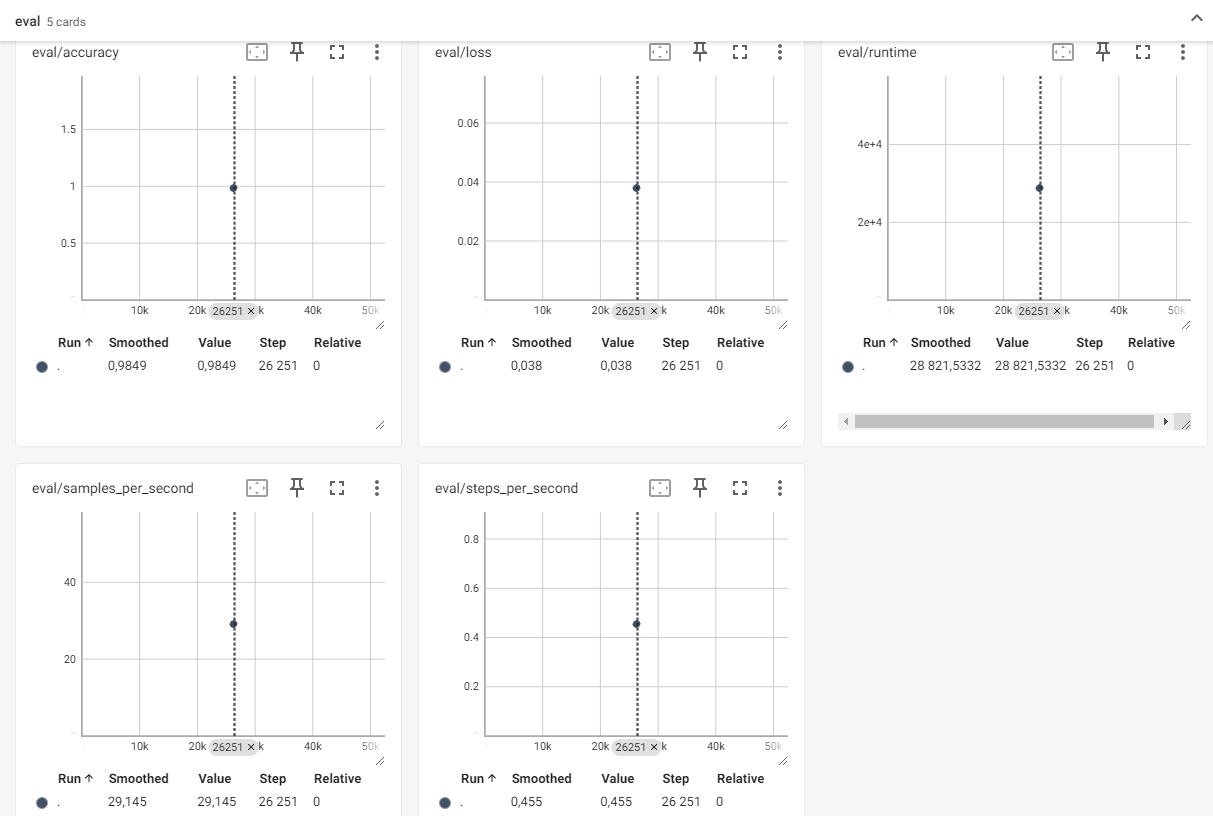

In [3]:
display(embed_image("pictures/eval_accuracy.png"))

Для train:

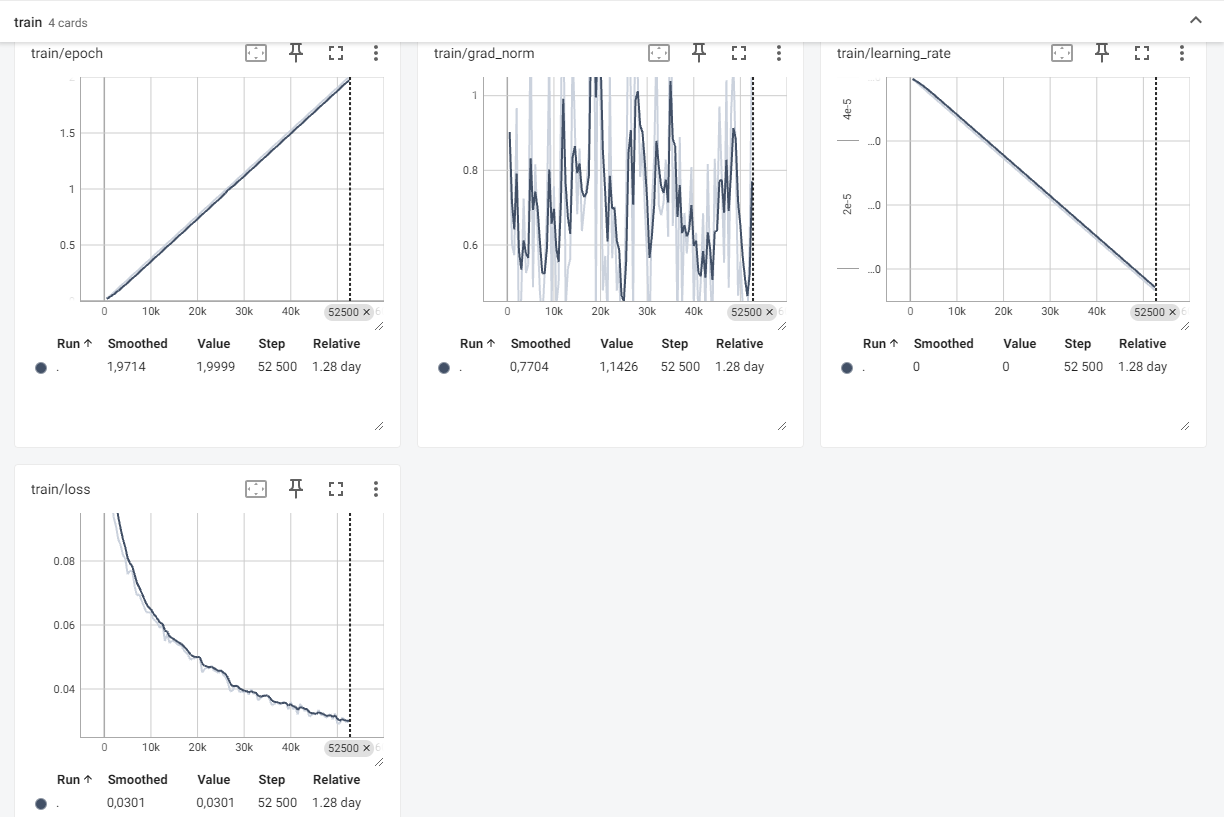

In [4]:
display(embed_image("pictures/train_accuracy.png"))